# Requirements

In [1]:
import os, sys 
import itertools
import collections
import random
import time 
import logging

from PIL import Image
from skimage import img_as_ubyte
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pyplot import imread

import torch
import torch.nn as nn
from torch.optim import Adam
from einops import rearrange

import deep_multiscale_GGLR_GGTV_v1x0 as model_structure


DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)
torch.set_float32_matmul_precision('high')

# Load Model/checkpoint 

In [2]:
training_state_path = os.path.join('/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/model_checkpoints/model_test31_v13_sigma25/checkpoints/checkpoints_epoch00_iter0795k.pt')
training_state = torch.load(training_state_path, weights_only=False)

model =  model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[96, 192, 384, 768],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8, 16, 16, 32], #[1, 2, 4, 8], 
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
model.load_state_dict(training_state["model"])

<All keys matched successfully>

# Flops count

In [3]:
import torch
from torch.utils.flop_counter import FlopCounterMode

def get_flops(model, inp, with_backward=False):
    
    istrain = model.training
    model.eval()
    
    inp = inp if isinstance(inp, torch.Tensor) else torch.randn(inp)

    flop_counter = FlopCounterMode(mods=model, display=False, depth=None)
    with flop_counter:
        if with_backward:
            model(inp).sum().backward()
        else:
            model(inp)
    total_flops =  flop_counter.get_total_flops()
    if istrain:
        model.train()
    return total_flops

In [4]:
SIGMA_TEST = 25.0
factor = 16
random_state = np.random.RandomState(seed=2204)

img = Image.open("/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png")
img_true_255 = np.array(img).astype(np.float32)
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
# noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

h,w = noisy_img.shape[2], noisy_img.shape[3]
H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
padh = H-h if h%factor!=0 else 0
padw = W-w if w%factor!=0 else 0
noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

flops = get_flops(model, noisy_img.to(DEVICE))

print(f"flops= {flops/1e9}")


/tmp/ipykernel_585909/2735743356.py:11: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(mods=model, display=False, depth=None)


flops= 246.966193152


In [5]:
noisy_img.shape

torch.Size([1, 3, 336, 496])

In [ ]:
336, 496

# Run testing big

In [ ]:

model.eval()
RESULT_ROOT = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/ImageRestoration-Development-Unrolling/exploration/model_multiscale_mixture_GLR/result_images"
MODEL_NAME = "LGU"
TEST_PATHS = [
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/CBSD68_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Kodak_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/McMaster_testing_data_info.csv',
    '/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/Urban100_testing_data_info.csv'
]

ROOT_DATASET = "/home/jovyan/shared/Thuc/hoodsgatedrive/projects/"

for test_path in TEST_PATHS:

    csv_path = os.path.join(test_path)
    img_infos = pd.read_csv(csv_path, index_col='index')


    paths = img_infos["path"].tolist()
    paths = [
        os.path.join(ROOT_DATASET,path)
        for path in paths
    ]

    SIGMA_TEST = 25.0
    factor = 16
    list_test_mse = []
    list_time_ops = []
    random_state = np.random.RandomState(seed=2204)
    test_i = 0
    for file_ in paths:
        torch.cuda.ipc_collect()
        torch.cuda.empty_cache()

        img = Image.open(file_)
        img_true_255 = np.array(img).astype(np.float32)
        img_true = img_true_255 / 255.0

        noisy_img_raw = img_true.copy()
        noisy_img_raw += random_state.normal(0, SIGMA_TEST/255., img_true.shape)
        # noisy_img_raw = np.clip(noisy_img_raw, 0, 1)

        noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
        noisy_img = noisy_img.unsqueeze(0)

        h,w = noisy_img.shape[2], noisy_img.shape[3]
        H,W = ((h+factor)//factor)*factor, ((w+factor)//factor)*factor
        padh = H-h if h%factor!=0 else 0
        padw = W-w if w%factor!=0 else 0
        noisy_img = nn.functional.pad(noisy_img, (0,padw,0,padh), 'reflect')

        
        s = time.time()
        with torch.no_grad():
            restored = model(noisy_img.to(DEVICE))
        time_cost = time.time() - s
        list_time_ops.append(time_cost)
        
        restored = restored[:,:,:h,:w]
        restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

        restored = img_as_ubyte(restored).astype(np.float32)
        test_mse_value = np.square(img_true_255- restored).mean()
        list_test_mse.append(test_mse_value)
        print(f"test_i={file_} time={time_cost} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
        test_i += 1
        s = time.time()

        # SAVE IMAGES RESULT
        filename = file_.split("/")[-1].split(".")[0]
        dataset_name = file_.split("/")[-2]
        denoised_img_path = RESULT_ROOT + "/{0}_sigma{1}_{2}_{3}_denoised.png".format(dataset_name, int(SIGMA_TEST), filename, MODEL_NAME)
        clean_img = img_true_255.astype(np.uint8)
        noise_img = img_as_ubyte(np.clip(noisy_img_raw, 0, 1)).astype(np.uint8)
        denoised_img = restored.astype(np.uint8)
        plt.imsave(denoised_img_path, denoised_img)
        
        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))
        # axs[0].imshow(clean_img)
        # axs[1].imshow(noise_img)
        # axs[2].imshow(denoised_img)
        # plt.show()
        # break
        
    psnr_testing = 20 * np.log10(255.0 / np.sqrt(list_test_mse))
    print(f"FINISH TESTING path={test_path} psnr_testing={np.mean(psnr_testing)} time_cost_avg={np.mean(list_time_ops)}")


test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0000.png time=3.1805977821350098 test_i_psnr_value=40.654335021972656
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0001.png time=1.2128715515136719 test_i_psnr_value=30.46282196044922
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0002.png time=1.1575911045074463 test_i_psnr_value=34.994529724121094
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0003.png time=1.252990961074829 test_i_psnr_value=30.873916625976562
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0004.png time=1.0122556686401367 test_i_psnr_value=30.536582946777344
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/CBSD68/0005.png time=1.0230481624603271 test_i_psnr_value=31.781370162963867
test_i=/home/jovyan/shared/Thuc/hoodsgatedrive/projects/dataset/GaussianTest/C

# Test Checkpoint 

time=0.37016868591308594 test_i_psnr_value=36.208473205566406


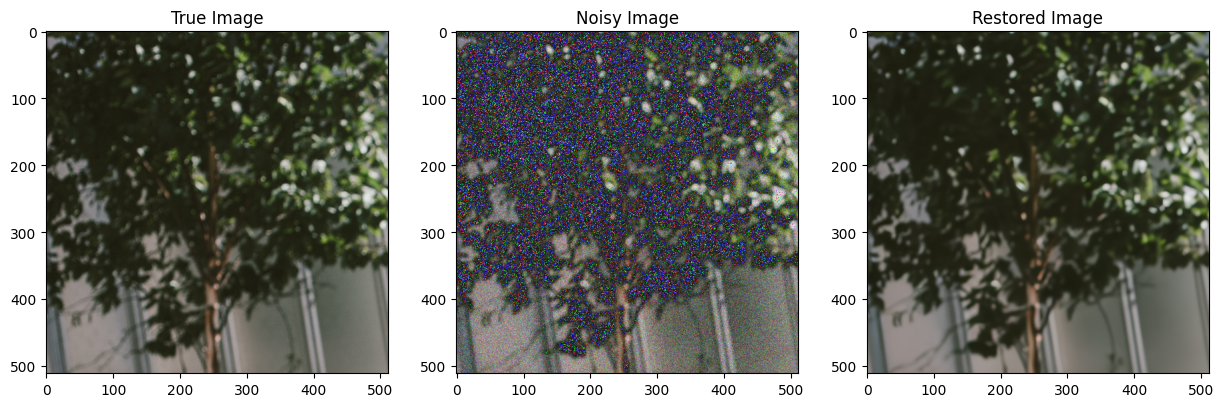

In [7]:

model.eval()

batchH, batchW = 512,512
sigma_test = 25.0
factor = 16
random_state = np.random.RandomState(seed=0)
s = time.time()

torch.cuda.ipc_collect()
torch.cuda.empty_cache()

img = Image.open("./0020.png")
img_true_255 = np.array(img).astype(np.float32)[:batchH, :batchW]
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

with torch.no_grad():
    restored = model(noisy_img.to(DEVICE))


restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

restored = img_as_ubyte(restored).astype(np.float32)
test_mse_value = np.square(img_true_255- restored).mean()
print(f"time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))

ax[0].imshow(img_true_255.astype(np.uint8))
ax[0].set_title("True Image")
ax[1].imshow((noisy_img_raw*255).astype(np.uint8))
ax[1].set_title("Noisy Image")
ax[2].imshow(restored.astype(np.uint8))
ax[2].set_title("Restored Image")

plt.show()




# Test Training simple

In [2]:
training_state_path = os.path.join('./checkpoint.pt')
training_state = torch.load(training_state_path, weights_only=False)

model =  model_structure.AbtractMultiScaleGraphFilter(
    n_channels_in=3, 
    n_channels_out=3, 
    dims=[48, 96, 192, 384],
    hidden_dims=[96, 192, 384, 768],
    nsubnets=[1, 1, 1, 1],
    ngraphs=[8, 16, 16, 32], #[1, 2, 4, 8], 
    num_blocks=[4, 6, 6, 8], 
    num_blocks_out=4
).to(DEVICE)
model.load_state_dict(training_state["model"])

criterian01 = nn.L1Loss()
criterian02 = nn.MSELoss()
loss02_weight = 0.1

optimizer = Adam(
    model.parameters(),
    lr=0.00001,
    eps=1e-08
)

In [3]:

model.eval()

batchH, batchW = 256, 256
sigma_test = 25.0
random_state = np.random.RandomState(seed=2215)
s = time.time()

torch.cuda.ipc_collect()
torch.cuda.empty_cache()

img = Image.open("./0020.png")
img_true_255 = np.array(img).astype(np.float32)[:batchH, :batchW]
img_true = img_true_255 / 255.0

for step_i in range(20):
    noisy_img_raw = img_true.copy()
    noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

    patchs_true = torch.from_numpy(img_true).permute(2,0,1).unsqueeze(0).to(DEVICE)
    patchs_noisy = torch.from_numpy(noisy_img_raw).permute(2,0,1).unsqueeze(0).to(DEVICE)

    # Forward
    s = time.time()
    patchs_reconstruct = model(patchs_noisy)
    patchs_true_reconstruct = model.enc_dec(patchs_true)

    ## Losses
    #### Main task denoising 
    loss01 = criterian01(patchs_reconstruct, patchs_true)
    #### Side loss to for encoding/decoding consistency
    loss02 = criterian02(patchs_true_reconstruct, patchs_true)
    loss_value = loss01 + 0.1 * loss02
    loss_value.backward()
    optimizer.step()
    
    # Eval
    restored = torch.clamp(patchs_reconstruct,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()
    restored = img_as_ubyte(restored).astype(np.float32)
    test_mse_value = np.square(img_true_255- restored).mean()
    print(f"time={time.time()-s} step={step_i} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  
    


time=1.1539483070373535 step=0 test_i_psnr_value=36.976654052734375
time=0.5641534328460693 step=1 test_i_psnr_value=37.00422668457031
time=0.5508038997650146 step=2 test_i_psnr_value=37.033203125
time=0.5469884872436523 step=3 test_i_psnr_value=37.01789093017578
time=0.5482895374298096 step=4 test_i_psnr_value=37.06385040283203
time=0.5465919971466064 step=5 test_i_psnr_value=37.035858154296875
time=0.5526132583618164 step=6 test_i_psnr_value=37.10481643676758
time=0.5481841564178467 step=7 test_i_psnr_value=37.04741668701172
time=0.5531136989593506 step=8 test_i_psnr_value=37.0782470703125
time=0.5487768650054932 step=9 test_i_psnr_value=37.15203857421875
time=0.5495016574859619 step=10 test_i_psnr_value=37.14736557006836
time=0.548494815826416 step=11 test_i_psnr_value=37.174495697021484
time=0.5504806041717529 step=12 test_i_psnr_value=37.10673522949219
time=0.5502524375915527 step=13 test_i_psnr_value=37.138160705566406
time=0.5483670234680176 step=14 test_i_psnr_value=36.99974441

time=0.3783590793609619 test_i_psnr_value=36.29191970825195


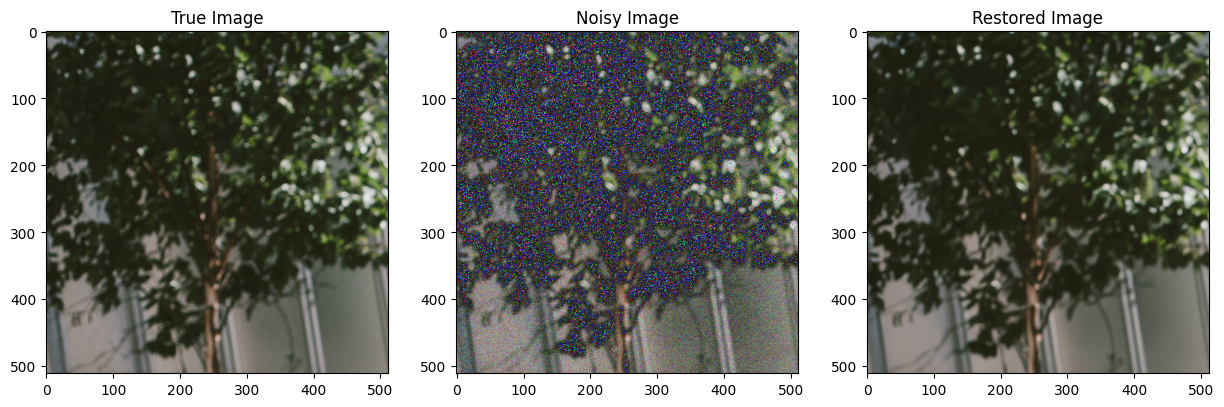

In [5]:

model.eval()

batchH, batchW = 512,512
sigma_test = 25.0
factor = 16
random_state = np.random.RandomState(seed=0)
s = time.time()

torch.cuda.ipc_collect()
torch.cuda.empty_cache()

img = Image.open("./0020.png")
img_true_255 = np.array(img).astype(np.float32)[:batchH, :batchW]
img_true = img_true_255 / 255.0

noisy_img_raw = img_true.copy()
noisy_img_raw += random_state.normal(0, sigma_test/255., img_true.shape)

noisy_img = torch.from_numpy(noisy_img_raw).permute(2,0,1)
noisy_img = noisy_img.unsqueeze(0)

with torch.no_grad():
    restored = model(noisy_img.to(DEVICE))


restored = torch.clamp(restored,0,1).cpu().detach().permute(0, 2, 3, 1).squeeze(0).numpy().copy()

restored = img_as_ubyte(restored).astype(np.float32)
test_mse_value = np.square(img_true_255- restored).mean()
print(f"time={time.time()-s} test_i_psnr_value={20 * np.log10(255.0 / np.sqrt(test_mse_value))}")  


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 8))

ax[0].imshow(img_true_255.astype(np.uint8))
ax[0].set_title("True Image")
ax[1].imshow((noisy_img_raw*255).astype(np.uint8))
ax[1].set_title("Noisy Image")
ax[2].imshow(restored.astype(np.uint8))
ax[2].set_title("Restored Image")

plt.show()


